# Kommersant

# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

In [0]:
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import seaborn as sns
sns.set()

In [0]:
import math

# Датасет kommersant. Предварительная обработка

Загрузим датасет kommersant. Одновременно сделаем преобразование даты из строки

In [0]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [0]:
data = pd.read_csv('/content/drive/My Drive/data/interim/kommersant/kommersant.csv',
                      sep='|',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"',
                      error_bad_lines=False)

b'Skipping line 18175: expected 6 fields, saw 7\nSkipping line 52548: expected 6 fields, saw 7\nSkipping line 88040: expected 6 fields, saw 7\nSkipping line 90060: expected 6 fields, saw 7\nSkipping line 112815: expected 6 fields, saw 7\nSkipping line 113987: expected 6 fields, saw 7\n'
b'Skipping line 182015: expected 6 fields, saw 7\nSkipping line 183963: expected 6 fields, saw 7\nSkipping line 188535: expected 6 fields, saw 7\nSkipping line 190143: expected 6 fields, saw 7\nSkipping line 192968: expected 6 fields, saw 7\nSkipping line 196199: expected 6 fields, saw 7\nSkipping line 202744: expected 6 fields, saw 7\nSkipping line 211650: expected 6 fields, saw 7\nSkipping line 214787: expected 6 fields, saw 7\nSkipping line 216208: expected 6 fields, saw 7\nSkipping line 219740: expected 6 fields, saw 7\nSkipping line 222588: expected 6 fields, saw 7\nSkipping line 227692: expected 6 fields, saw 7\nSkipping line 230516: expected 6 fields, saw 7\nSkipping line 230533: expected 6 field

In [0]:
# Проверим преобразование
data.dtypes

date     datetime64[ns]
url              object
-                object
topic            object
title            object
text             object
dtype: object

In [0]:
data.shape

(606175, 6)

In [0]:
# Так выглядет датасет kommersant
data.head()

,date,url,-,topic,title,text
0,2000-05-09 00:00:00,https://www.kommersant.ru/doc/16881,-,Потребительский рынок,Microsoft: писать раздельно,"Каждый день, когда миллионы людей во всем мире..."
1,2000-10-31 00:00:00,https://www.kommersant.ru/doc/17910,-,Финансы. Рынок,ЦБ удержит курс доллара?,1. Что будет с долларом?nВ предыдущем прогнозе...
2,2001-01-30 00:00:00,https://www.kommersant.ru/doc/136058,-,Потребительский рынок,"Чтобы получить ВАЗ, Fiat раскрыл нам военные с...",NaN
3,2001-04-03 00:00:00,https://www.kommersant.ru/doc/253496,-,За границей,Россия в цифрах,23 человекаnпогибли иn142nпострадали в результ...
4,2001-04-10 17:13:00,https://www.kommersant.ru/doc/918337,-,Политика,Селезнев: России нужно думать о создании новой...,10 апреля спикер Государственной Думы РФ Генна...


In [0]:
# Выясним в каким столбцах есть пустые данные
data.isnull().any()

date     False
url      False
-        False
topic    False
title     True
text      True
dtype: bool

In [0]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data['text'].isnull().sum())
data[data['text'].isnull()].head()

Кол-во строк с значением NaN в столбце "Text" =  39320


,date,url,-,topic,title,text
2,2001-01-30 00:00:00,https://www.kommersant.ru/doc/136058,-,Потребительский рынок,"Чтобы получить ВАЗ, Fiat раскрыл нам военные с...",NaN
7,2001-04-10 14:05:00,https://www.kommersant.ru/doc/918329,-,Культура,"В Москве открылась выставка Праздник хлеба""""""|...",NaN
16,2001-04-10 18:54:00,https://www.kommersant.ru/doc/918339,-,Политика,Путин и Шредер посетили музей-заповедник Царск...,NaN
26,2001-04-11 16:12:00,https://www.kommersant.ru/doc/918367,-,Культура,Ко Дню космонавтики будет отремонтирована плат...,NaN
49,2001-04-11 12:53:00,https://www.kommersant.ru/doc/918365,-,Политика,В Москве начинается месячник Чистый автомобил...,NaN


In [0]:
#Удалим эти строки
data.drop(data[data.text.isnull()].index, inplace=True)

In [0]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


In [0]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data.text.duplicated().sum())

Кол-во одинаковых текстов: 420


In [0]:
# Удаление дубликатов
data = data.drop_duplicates(subset='text')

In [0]:
data.shape

(566435, 6)

# EDA

## Анализ дат

In [0]:
print('Минимальная дата в датасете:', data.date.min())
print('Максимальная дата в датасете:', data.date.max())

Минимальная дата в датасете: 2000-05-09 00:00:00
Максимальная дата в датасете: 2019-04-10 13:00:18


### Распределение количества новостей по месяцам

In [0]:
# Вынесем месяц и год новости в отдельные столбцы
data['month'] = data.date.apply(lambda x: x.month)
data['year'] = data.date.apply(lambda x: x.year)

# Создадим отдельный датасет посчитаем количество новостей в разрезе месяца и года
df = data.groupby(['year', 'month']).text.nunique().reset_index()

In [0]:
df.head()

,year,month,text
0,2000,5,1
1,2000,10,1
2,2001,4,635
3,2001,5,875
4,2001,6,806


In [0]:
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)

In [0]:
df.columns = ['year', 'month', 'nunique_text', 'month_year']

In [0]:
# выберем только те месяцы, в которых количество новостей больше 10
df = df[df.nunique_text>10]

In [0]:
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head()

,month_year,nunique_text
181,03-2016,5666
182,04-2016,5654
174,08-2015,5567
176,10-2015,5537
186,08-2016,5486


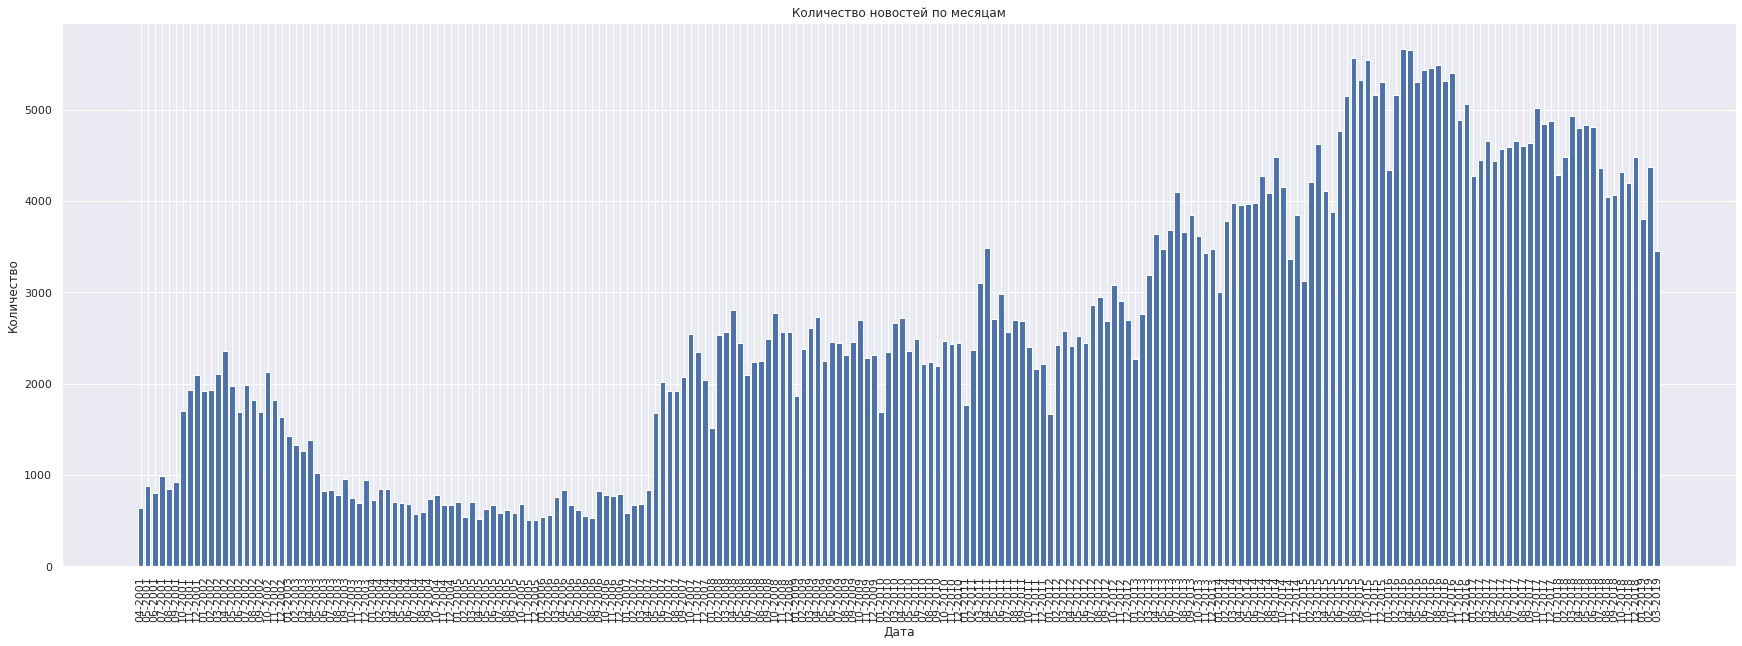

In [0]:
fig, ax = plt.subplots(figsize=(30, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')

ax.set_title('Количество новостей по месяцам')
ax.set_ylabel('Количество')
ax.set_xlabel('Дата')
plt.show()

## Рубрики Kommersant

In [0]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data.topic.unique().shape)
data['topic'].unique()

Количество рубрик =  (59,)


array(['Потребительский рынок', 'Финансы. Рынок', 'За границей',
       'Политика', 'Общество', 'Спорт', 'Культура', 'Происшествия', 'Мир',
       'Бизнес', 'Дороги и ДТП', 'Промышленность', 'Технологии',
       'Экономика', 'Автосалон', 'Реклама', 'Ъ-FM/Темы дня',
       'Ъ-FM/Программы', 'Ъ-FM/Спецпроекты', 'Ъ-FM/Интервью',
       'Ъ-FM/В эфире', 'Финансы', 'Страна', 'Бизнес|Культура',
       'ПДД и законы', 'ЦМТ/Новости', 'ЦМТ/Интервью', 'ЦМТ/Аналитика',
       'WTC/Analytics', 'WTC/Interviews', 'Автошколы', 'За городом',
       'Идеи и важные вещи', 'События', 'Гаджеты', 'Авто', 'Накопить',
       'Сэкономить', 'Занять', 'Инвестировать', 'Наука', 'В городе',
       'Недвижимость. Рынок', 'Недвижимость', 'Hi-Tech', 'Стартапы',
       'Hi-Tech. Рынок', 'Стиль', 'Идеи', 'Важные вещи',
       'Ъ-FM-НН/Программы', 'Политика|Общество', 'Инициативы',
       'Путешествия', 'Конференции/Трансляции', 'Конференции/Эксклюзив',
       'Конференции/Отчеты', 'Конференции/Интервью',
       'Потреб

### Все рубрики, с количеством новостей в каждой группе

In [0]:
data.groupby('topic')['topic'].count().sort_values(ascending=False)

topic
Мир                                     140068
Происшествия                             83772
Общество                                 55918
Политика                                 55519
Бизнес                                   54698
Спорт                                    35704
Ъ-FM/Темы дня                            27988
Культура                                 23456
Потребительский рынок                    18600
Экономика                                17369
Промышленность                           15622
Финансы. Рынок                            9492
Ъ-FM/Программы                            8018
Финансы                                   7042
Реклама                                   2211
Страна                                    1978
Стиль                                     1599
Hi-Tech                                   1436
Идеи и важные вещи                        1195
Автосалон                                  621
Hi-Tech. Рынок                             526
Инвести

## Анализ заголовков и текста новостей

In [0]:
## Соберем в отдельные столбцы длину заголовка и текста новости

In [0]:
data['title_len'] = data.title.apply(lambda x: len(x))

In [0]:
data['text_len'] = data.text.apply(lambda x: len(x))

### Анализ заголовков

In [0]:
data.title_len.describe()

count    566435.000000
mean         57.537232
std         222.652299
min           1.000000
25%          36.000000
50%          50.000000
75%          66.000000
max       47709.000000
Name: title_len, dtype: float64

Видно, что получившиеся длины заголовков, содержат аномально большие значения, попрубуем разобраться в этом

Построим гистограмму и боксплот для первичного анализа

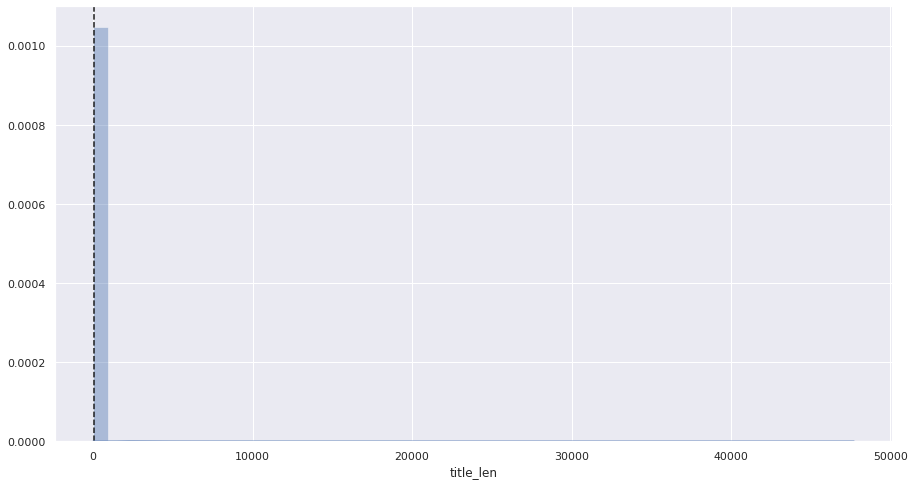

In [0]:
plt.subplots(figsize=(15, 8))
plt.axvline(data['title_len'].median(), color="k", linestyle="--");
sns.distplot(data['title_len']);

Ничего не понятно, попробуем изменить количество интервалов

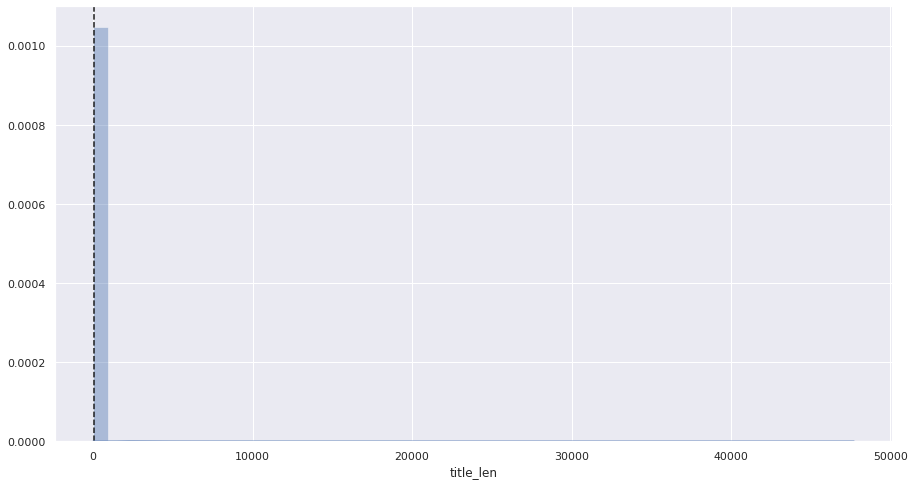

In [0]:
plt.subplots(figsize=(15, 8))
plt.axvline(data['title_len'].median(), color="k", linestyle="--");
sns.distplot(data['title_len'], bins=50);

Все равно ничего не понятно, поробуем применить формулу Стреджерса для определения оптимального количества интервалов

Количество по формуле Стреджерса, с окркуглением к меньшему целому составляет:  20


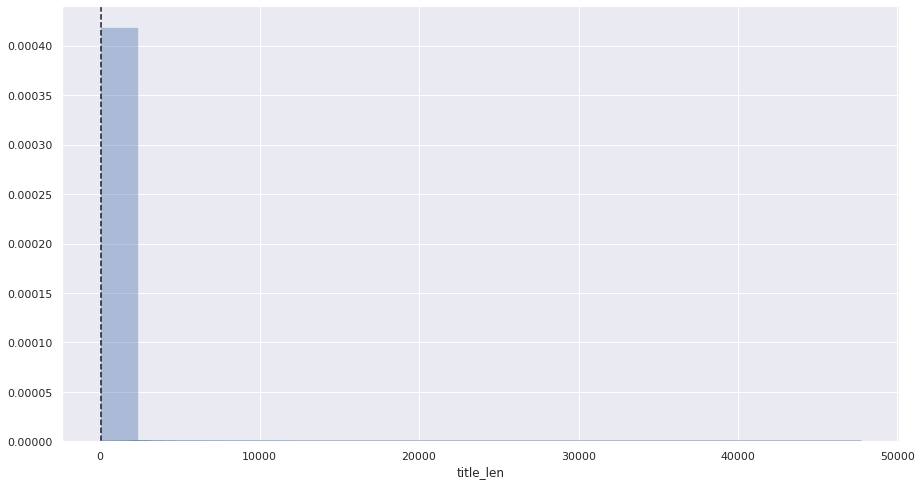

In [0]:
# По формуле Стреджерса
print('Количество по формуле Стреджерса, с округлением к меньшему целому составляет: ', math.floor(1 + 3.322*math.log10(566435)))
plt.subplots(figsize=(15, 8))
plt.axvline(data['title_len'].median(), color="k", linestyle="--");
sns.distplot(data['title_len'], bins=math.floor(1 + 3.322*math.log10(566435)));

Тоже не лучше, может боксплот покажет что-нибудь интересное

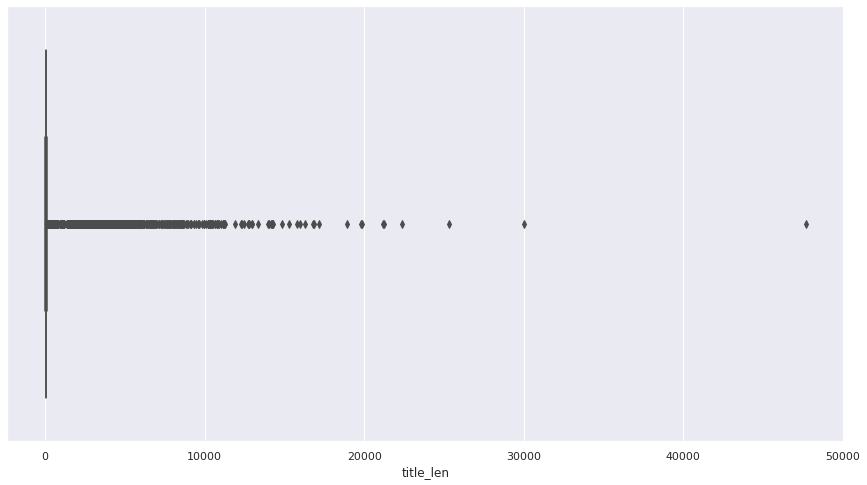

In [0]:
plt.subplots(figsize=(15, 8))
sns.boxplot(x='title_len', data=data);

Результат, конечно, так себе. Попробуем сделать следующее.
Для уменьшения такого длинного ряда, применим десятичный логарифм к тем строкам, где количество символов в заголовке больше 250 (число может быть любое). Таким образом, мы уменьшим разброс, но при этом также увидим эти аномалии на графике

In [0]:
# Создадим еще один столбец, где еще раз посчитаем длину заголовков, но
# с условием: те длины, которые больше 250 мы будем логарифмировать, для уменьшения разброса
# коэффициент 10, перед логарифмом нужен лишь для того, чтобы лучше было видно выбросы
data['title_len_lg'] = data.title.apply(lambda x: (len(x) if len(x)<=250 else 10*math.log10(len(x))+250))

In [0]:
data['title_len_lg'].describe()

count    566435.000000
mean         51.499539
std          22.556366
min           1.000000
25%          36.000000
50%          50.000000
75%          66.000000
max         296.786003
Name: title_len_lg, dtype: float64

посмотрим, что теперь получилось с гистограммой и боксплотом, начнем в этот раз с боксплота

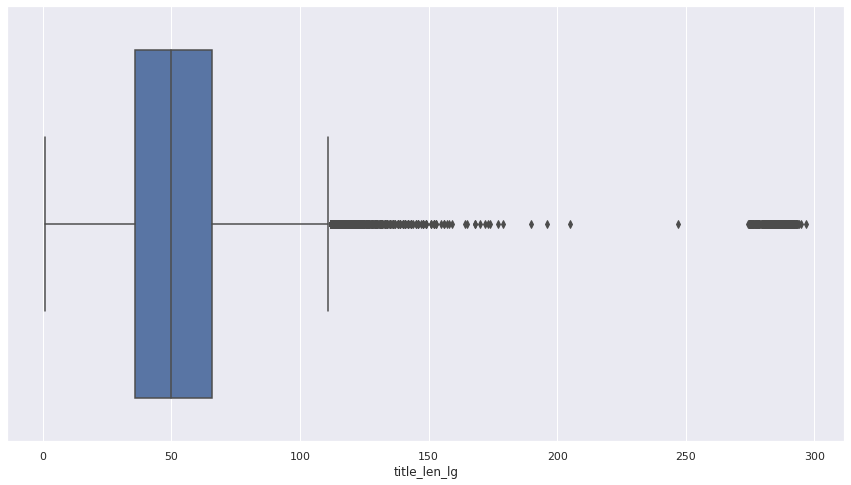

In [0]:
plt.subplots(figsize=(15, 8))
sns.boxplot(x='title_len_lg', data=data);

Уже неплохо. Посмотрим, что там с гистограммами

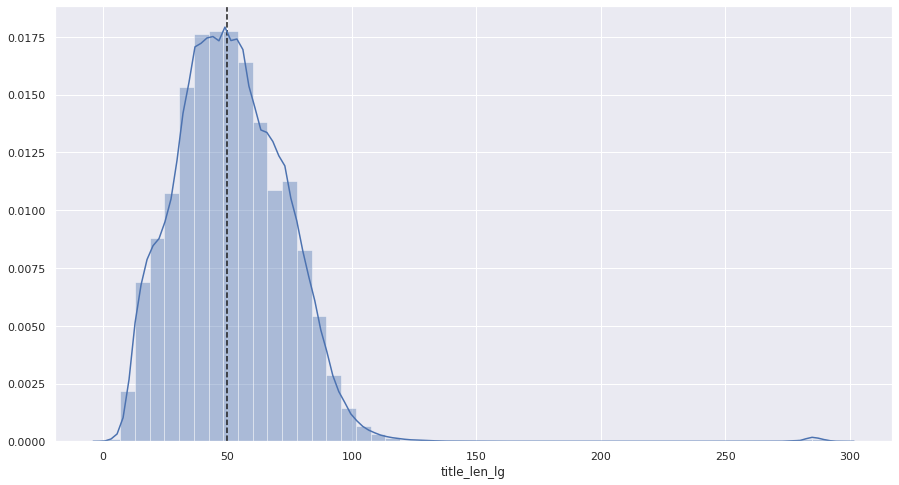

In [0]:
# Без указания количества интервалов
plt.subplots(figsize=(15, 8))
plt.axvline(data['title_len_lg'].median(), color="k", linestyle="--");
sns.distplot(data['title_len_lg']);

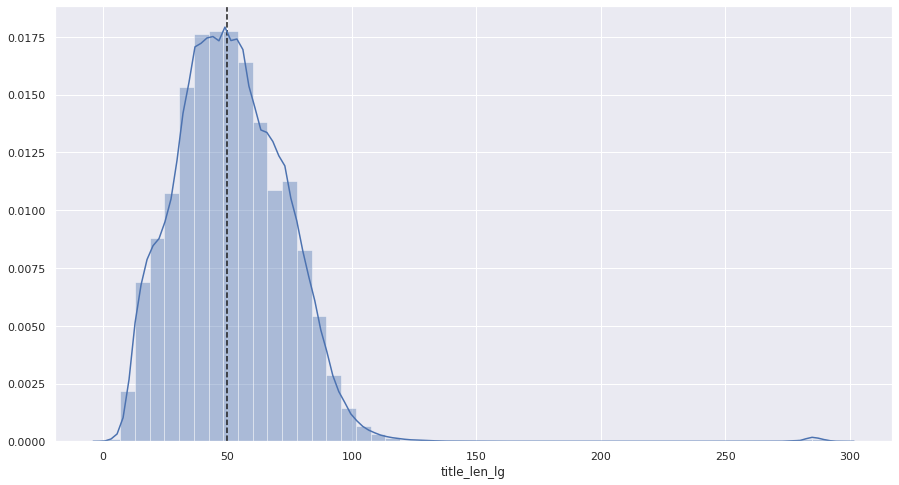

In [0]:
# Количество интервалов = 50
plt.subplots(figsize=(15, 8))
plt.axvline(data['title_len_lg'].median(), color="k", linestyle="--");
sns.distplot(data['title_len_lg'], bins=50);

Количество по формуле Стреджерса, с округлением к меньшему целому составляет:  20


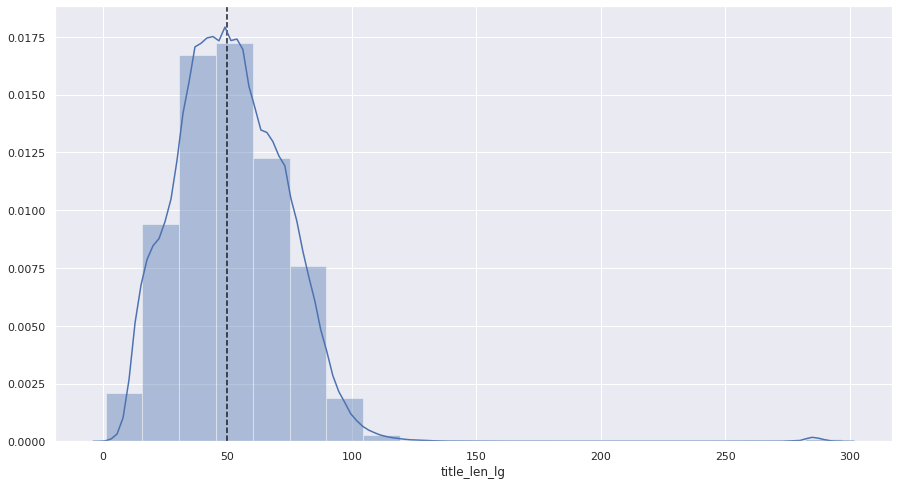

In [0]:
# По формуле Стреджерса
print('Количество по формуле Стреджерса, с округлением к меньшему целому составляет: ', math.floor(1 + 3.322*math.log10(566435)))
plt.subplots(figsize=(15, 8))
plt.axvline(data['title_len_lg'].median(), color="k", linestyle="--");
sns.distplot(data['title_len_lg'], bins=math.floor(1 + 3.322*math.log10(566435)));

Результат неплохой, посмотрим, какое количество строк в нашем датасете, выходит за рамки наших усов (Все, что выше суммы третьего квартиля и полутора межквартильных расстояний)
межквартильных расстояний = 66 - 36 = 30
Верхняя граница наблюдаемых значений = 66 + 1.5 * 30 = 111

In [0]:
(data.title_len_lg > 111).sum()

2117

2117 Новостей содержат аномально большие заголовки, скорей всего там что-то не так с данными (возможно слияние заголовка и новости). Можно исключить такие новости из датасета.

Глянем, что там такое, возьмем для примера с максимальной длинной

In [0]:
data[(data['title_len'] == data['title_len'].max())]

,date,url,-,topic,title,text,month,year,title_len,text_len,title_len_lg
263626,2013-02-14 00:08:35,https://www.kommersant.ru/doc/2126890,-,Общество,В этом городе не может быть маленьких проектов...,Россияне смогут вернуть все налоги за проданны...,2,2013,47709,2497,296.786003


In [0]:
str(data[data.index == 263626].title.values)

'[\'В этом городе не может быть маленьких проектов"""|Мэр Москвы СЕРГЕЙ СОБЯНИН на встрече с редакцией “Ъ” рассказал о том, как следит за уборкой снега в Москве, что главное в транспортной стратегии города и что будет дальше со стадионом «Лужники». Господин Собянин считает, что в Москве надо проводить выборы главы города, но пока не знает, кто будет у него в конкурентах.n— У вас есть нарекания к работе коммунальных служб в этом сезоне? Многие граждане считают, что впервые за много лет город убирается из рук вон плохо.n— У меня много замечаний и претензий к коммунальщикам. За это время десятки должностных лиц были уволены, а некоторые из них даже посажены за коррупцию. Количество административных штрафов выросло со 170\\xa0млн руб. в 2010 году до 1\\xa0млрд 800\\xa0млн руб. за прошедший год. Такого административного нажима на коммунальщиков не было никогда. Но и такого объема работ тоже не было. За последние 100 лет ни разу не было столько снега и ледяных дождей. Для примера могу сказат

In [0]:
str(data[data.index == 263626].text.values)

'[\'Россияне смогут вернуть все налоги за проданные акции. Такое предложение подготовила Национальная ассоциация участников фондового рынка. Ситуацию ведущему Алексею Корнееву прокомментировала генеральный директор компании Персональный советник" Наталья Смирнова.nПланируется, что при продаже ценных бумаг, которыми человек владел не менее трех лет, он сможет вернуть налог на доходы физических лиц с суммы в 3 млн руб. Если же акции находились в собственности более пяти лет, то ограничений по возвращению налогов не будет.nКроме того, финансисты предлагают ввести два новых вида инвестиционных вкладов. Владельцам таких счетов будет возвращаться подоходный налог с дохода по вкладу — 13%. Предполагается, что Госдума рассмотрит эти предложения уже в весеннюю сессию.n— Как можно вообще оценить эти инициативы? Они каким-то образом смогут привлечь россиян к инвестициям внутри страны?n— Во-первых, да, безусловно, и к этому мы давно шли. Другое дело, что у нас уже одно время был налоговый вычет в 

Ощущение, что в заголовок слепили несколько новостей. При этом продолжение последний новости из заголовка находится в столбце text

#### Столбчатая диаграмма

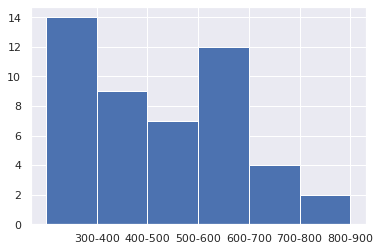

In [0]:
bins = [300, 400, 500, 600, 700, 800, 900]
data_my = data.title_len.values
hist, bin_edges = np.histogram(data_my, bins)
fig, ax = plt.subplots()
ax.bar(range(len(hist)), hist, width=1)
ax.set_xticks([0.5 + i for i, j in enumerate(hist)])
ax.set_xticklabels(['{}-{}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)])
plt.show()

In [0]:
((data['title_len'] >= 300) & (data['title_len'] < 400)).sum()

14

In [0]:
(data['title_len'] >= 800).sum()

770

### Анализ текста новостей

In [0]:
data.text_len.describe()

count    566435.000000
mean       2217.590297
std        2924.279705
min          10.000000
25%         590.000000
50%        1213.000000
75%        3165.000000
max      387478.000000
Name: text_len, dtype: float64

Видно, что получившиеся длины, также содержат аномально большие значения. На этот раз мы сразу прологарифмируем значения и начнем с построения боксплота

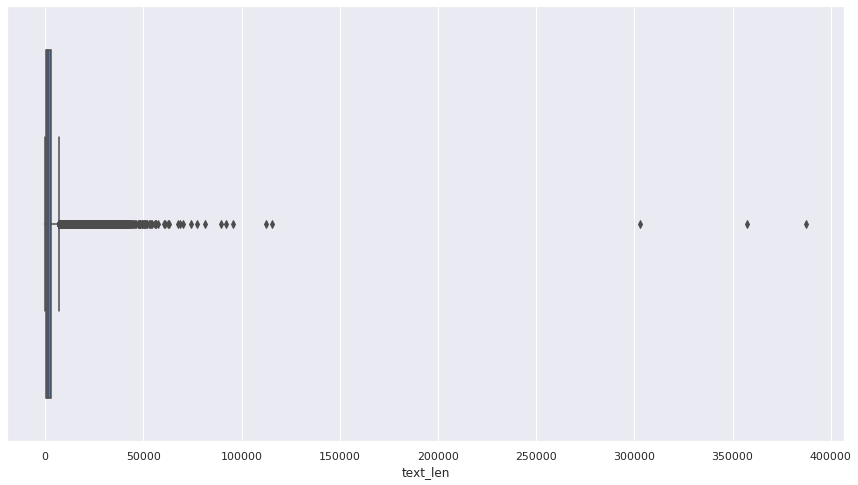

In [0]:
plt.subplots(figsize=(15, 8))
sns.boxplot(x='text_len', data=data);

In [0]:
# Верхняя граница наблюдаемых значений = 3165 + 1.5 * (3165 - 590) = 7027
print('Межквартильный размах: ', data.text_len.quantile(q=0.75) - data.text_len.quantile(q=0.25))
print('Верхняя граница наблюдаемых значений: ', data.text_len.quantile(q=0.75) + 1.5 * (data.text_len.quantile(q=0.75) - data.text_len.quantile(q=0.25)))

Межквартильный размах:  2575.0
Верхняя граница наблюдаемых значений:  7027.5


In [0]:
data['text_len_lg'] = data.text.apply(lambda x: (len(x) if len(x)<=10000 else 10*math.log10(len(x))+10000))

In [0]:
data['text_len_lg'].describe()

count    566435.000000
mean       2100.634354
std        2187.537346
min          10.000000
25%         590.000000
50%        1213.000000
75%        3165.000000
max       10055.882470
Name: text_len_lg, dtype: float64

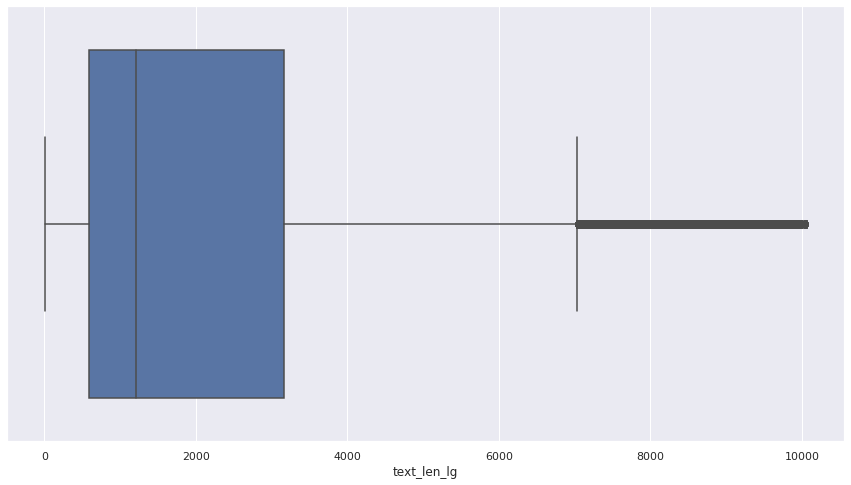

In [0]:
plt.subplots(figsize=(15, 8))
sns.boxplot(x='text_len_lg', data=data);

Количество по формуле Стреджерса, с округлением к меньшему целому составляет:  20


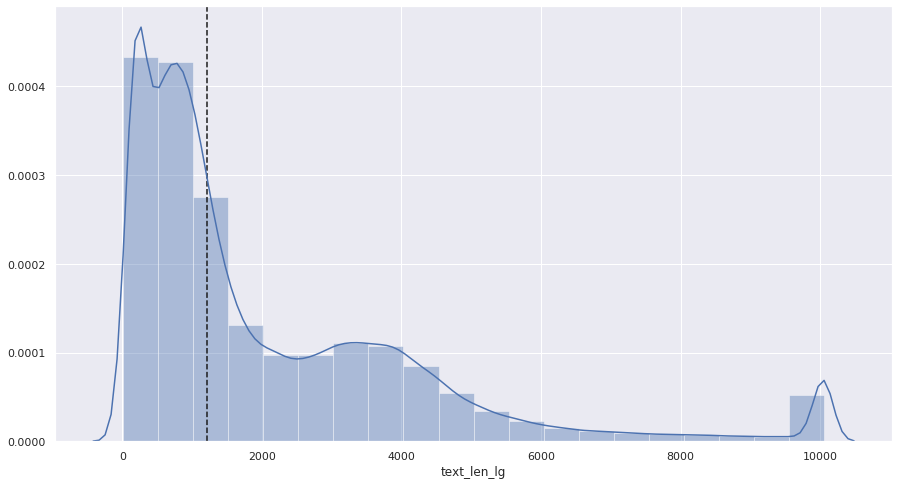

In [0]:
# По формуле Стреджерса
print('Количество по формуле Стреджерса, с округлением к меньшему целому составляет: ', math.floor(1 + 3.322*math.log10(566435)))
plt.subplots(figsize=(15, 8))
plt.axvline(data['text_len_lg'].median(), color="k", linestyle="--");
sns.distplot(data['text_len_lg'], bins=math.floor(1 + 3.322*math.log10(566435)));

In [0]:
# Верхняя граница наблюдаемых значений = 3165 + 1.5 * (3165 - 590) = 7027
print('Межквартильный размах: ', data.text_len_lg.quantile(q=0.75) - data.text_len_lg.quantile(q=0.25))
print('Верхняя граница наблюдаемых значений: ', data.text_len_lg.quantile(q=0.75) + 1.5 * (data.text_len_lg.quantile(q=0.75) - data.text_len_lg.quantile(q=0.25)))

Межквартильный размах:  2575.0
Верхняя граница наблюдаемых значений:  7027.5


In [0]:
(data.text_len_lg > 7027).sum()

24978

24978 новости содержат аномально большие тексты, скорей всего там что-то не так с данными. Можно исключить такие новости из датасета.

#### Столбчатая диаграмма

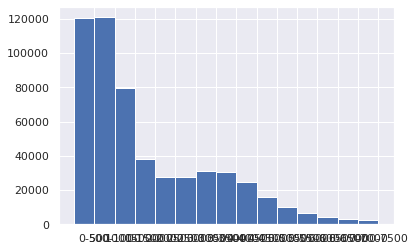

In [0]:
bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500]
data_my = data.text_len.values
hist, bin_edges = np.histogram(data_my, bins)
fig, ax = plt.subplots()
ax.bar(range(len(hist)), hist, width=1)
ax.set_xticks([0.5 + i for i, j in enumerate(hist)])
ax.set_xticklabels(['{}-{}'.format(bins[i], bins[i+1]) for i, j in enumerate(hist)])
plt.show()

In [0]:
((data['text_len'] > 7500)).sum()

22459